# What is a class?

From Python documentation (https://docs.python.org/3/tutorial/classes.html):

>Classes provide a means of bundling data and functionality together. Creating a new class creates a new type of object, allowing new instances of that type to be made. Each class instance can have attributes attached to it for maintaining its state. Class instances can also have methods (defined by its class) for modifying its state.

This is a very powerful concept, especially for software development. It has its merits for data analysis as well. Let's create a simplest class.

In [1]:
class MyClass:
    """A simple example class"""
    i = 12345

    def f(self):
        return 'hello world'

In [2]:
MyClass

__main__.MyClass

In [3]:
a = MyClass()

In [4]:
a.i

12345

In [5]:
a.f()

'hello world'

One might ask -- why do we even need classes? Couldn't we do the same thing by defining function `f` and assigning `i = 12345` outside the class?

In [6]:
i = 12345

def f():
    return 'hello world'

In [7]:
print(i)
f()

12345


'hello world'

It is a good question, and one answer is that with increasing number of elements (data and functions), complexity of the code will grow much more without the classes than without the classes. Indeed, sometimes a carefully created class allows to descrease the complexity of the code significantly.

# Condering existing class

Perhaps it is useful to look at some of the classes we have used, e.g. `pandas.DataFrame`.

In [8]:
import pandas as pd
import numpy as np
untidy = pd.DataFrame({'treatment_a':[7, 16, 3],'treatment_b':[2,11,1]}, 
                      index=['John Smith', 'Jane Doe','Mary Johnson'])
untidy

,treatment_a,treatment_b
John Smith,7,2
Jane Doe,16,11
Mary Johnson,3,1


We could have the same values in a list, like this:

In [9]:
values = [[7, 16, 3],[2,11,1]]
values

[[7, 16, 3], [2, 11, 1]]

And we could have even the labels as separate lists:

In [10]:
index = ['John Smith', 'Jane Doe','Mary Johnson']
columns = ['treatment_a','treatment_b']

Now, let's say we want to calculate means for each column. We could use a numpy method to do it:

In [11]:
print(columns, '\n', np.mean(values, axis=1))

['treatment_a', 'treatment_b'] 
 [8.66666667 4.66666667]


And it is all fine so far. However, imagine now that we want to do other actions on the data, and we want to keep track of labels and columns. We wrote some functions, but we need to pass the `columns`, `index` and `values` every time. This is inconvenient and prone to errors.

If you have data and you need to run some operations on that data, it is worth considering creating a class. Especially if you're passing the data through multiple stages of processing, like in the case of EEG processing. As an example, that is why in the `mne` library `Epochs` and `Raw` are classes, and not just `numpy` arrays. They have integrated events structure and many operations (methods) for dealing with these data.

# Consider a class from an actual application

Classes are one of these things which purpose and convenience is difficult to understand before facing a problem solved well by a careful introduction of a class. For this reason classes are quite difficult to teach. At the same time, since they are used everywhere, you need to understand how they work. Let's consider a class from a real application, this will let us talk through some of its elements.

In [12]:
class DataQuery():

    def __init__(self, fname, ix_min, ix_max):
        self.fname = fname
        self.ix_min = ix_min
        self.ix_max = ix_max

    def __repr__(self):
        return 'DataQuery: {}, {:>6} -> {:>6}'.format(
            self.fname, self.ix_min, self.ix_max)
        
    def get_data(self):
        data = pd.read_csv(self.fname, header=None, index_col=0).values
        if self.ix_min>=0 and self.ix_max>=0:
            epoch_data = data[self.ix_min:self.ix_max+1,:].copy().T
        elif self.ix_max<0:
            epoch_data = np.full((data.shape[1], self.ix_max - self.ix_min + 1),
                                 fill_value=np.nan)
        elif self.ix_min<0:
            epoch_data = data[:self.ix_max+1,:].copy().T
            null_part = np.full((data.shape[1], -self.ix_min), fill_value=np.nan)
            epoch_data = np.concatenate([null_part,epoch_data], axis=1)
        return epoch_data

This class implements a DataQuery, i.e. it is a way to get the data from a certain file around certain indexes. Think about it as the data for a single EEG epoch.

First we create an instance of a class: a dataquery. We need to look at the method `__init__` which is the method called when the instance of a class is created. It will tell us which inputs the class requires. In our case it is `fname, ix_min, ix_max, data_fmt`. Note that this method MUST have this particular name `__init__`, and no other name, to be called when the class is created. This is an example of a group of special methods, called "dunder methods", which is short for "double underscore methods", referring to the fact that they are prefixed and postfixed by double underscore. We will see some examples of these methods in the future. But keep in mind that they always do something special and they are never intended to be called directly by the user.

Let's create an instance of DataQuery.

In [13]:
dq = DataQuery('data/eeg.csv', 100, 1100)

To make sure that `__init__` method is called when the class is created, you can try to add some `print`s to it and rerun the previous line.

We can now leverage on some of the functionality of the DataQuery class. For example, we can use its method `get_data()` to actually get the EEG data from the file.

In [14]:
dq.get_data().shape

(2, 1001)

It has 2 channels and 1001 points (because DataQuery implementation includes both ends of the query).

Let's plot the data:

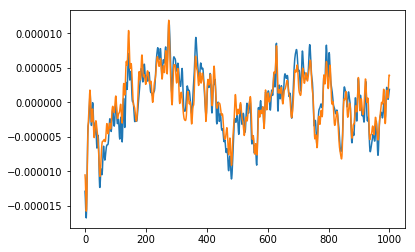

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(dq.get_data().T)

There is another dunder method in the class: `__repr__`. This method allow you to create a string representation of the class, which is invoked whenever the class is printed for the user to see. This can be extremely useful for usability and debugging. In this string representation I included the file name and the indexes which are specified in the query:

In [16]:
print(dq)

DataQuery: data/eeg.csv,    100 ->   1100


Now an important lesson. Why do classes decrease the complexity of the code? Because once the class is created and its functionality is implemented, you can abstract away from the low-level details (in this case, how the data is extracted) and just focus on what you need to do. 

I need to extract multiple epochs of the size 1001 points at various indexes. I can do it the following way.

In [17]:
## create data queries
# ixs of the stimulation
ixs_stim = [57,3213,4424,6123,7234]
win_size = 1000
dqs = [DataQuery('data/eeg.csv',ix,ix+win_size) for ix in ixs_stim]
# print queries for inspection
[print(dq) for dq in dqs]

DataQuery: data/eeg.csv,     57 ->   1057
DataQuery: data/eeg.csv,   3213 ->   4213
DataQuery: data/eeg.csv,   4424 ->   5424
DataQuery: data/eeg.csv,   6123 ->   7123
DataQuery: data/eeg.csv,   7234 ->   8234


[None, None, None, None, None]

In [18]:
data = np.array([dq.get_data() for dq in dqs])
data.shape

(5, 2, 1001)

Just like that I can get the data for my epochs, knowing that the class will take care of data retrieval. Yes, I could do it without the introductiong of the class, but it would be much more involved, with a parameters passing from one function to another. And, more importantly, if I wanted to add some functionality, it would be simpler to do with the class.

# Inheritance
A very important property of the classes which you need to be aware of is inheritance. The classes we created before that we created "from scratch", but classes can be also created on top of other classes. In this case everything that the parent class had (all attributes and methods) will be inherited by the child class. But the child class can change some of them or add new methods/attributes.

Sometimes it is much more useful to subclass already existing class. For example, I really want to have a class that is similar to list, but I want to be able to reverse it easily. I can do it in the following way:

In [32]:
class ReversableList(list):
    
    def rev(self):
        return self[::-1]

In [33]:
alphabet = ReversableList(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
alphabet

['a', 'b', 'c', 'd', 'e', 'f', 'g']

In [41]:
alphabet.rev()

['g', 'f', 'e', 'd', 'c', 'b', 'a']

In all other ways my `ReversableList` will behave in exactly same way as a normal `list`. E.g. it inherited method `pop` from the `list`:

In [42]:
alphabet.pop(0)

'a'